## Домашнее задание к уроку 4. Сверточные нейронные сети

Вариант 1. (простой)

    - обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг (conv-pool)-(conv-pool)-...) на датасете fashion-mnist
    - оценить рост точности при увеличении ширины сети (больше ядер)
    - оценить рост точности при увеличении глубины сети (больше слоев)
    - сравнить с точностью полносвязной сети для этой выборки

---

In [1]:
# Загрузка библиотек

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers, losses, datasets

from tensorflow.keras.losses import categorical_crossentropy

In [2]:
# Загрузка данных

(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

x_train = tf.pad(x_train, [[0, 0], [2,2], [2,2]])/255
x_test = tf.pad(x_test, [[0, 0], [2,2], [2,2]])/255

x_train = tf.expand_dims(x_train, axis = 3, name = None)
x_test = tf.expand_dims(x_test, axis = 3, name = None)

x_train = tf.repeat(x_train, 3, axis = 3)
x_test = tf.repeat(x_test, 3, axis = 3)

x_val = x_train[-2000:,:,:,:]
y_val = y_train[-2000:]
x_train = x_train[:-2000,:,:,:]
y_train = y_train[:-2000]

2022-04-18 20:19:10.942557: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

In [3]:
# Пустая модель

model = Sequential()

model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation = "bilinear", input_shape = x_train.shape[1:]))

model.add(layers.Conv2D(96, 11, strides = 4, padding = 'same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides = 2))

model.add(layers.Conv2D(256, 5, strides = 4, padding = 'same'))
model.add(layers.Lambda(tf.nn.local_response_normalization))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(3, strides = 2))

model.add(layers.Conv2D(384, 3, strides = 4, padding = 'same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(384, 3, strides = 4, padding = 'same'))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(256, 3, strides = 4, padding = 'same'))
model.add(layers.Activation('relu'))

model.add(layers.Flatten())

model.add(layers.Dense(4096, activation = 'relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(4096, activation = 'relu'))
model.add(layers.Dropout(0.5))

model.add(layers.Dense(10, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
lambda (Lambda)              (None, 56, 56, 96)        0         
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 256)         614656    
_________________________________________________________________
lambda_1 (Lambda)            (None, 7, 7, 256)         0

In [4]:
# Компиляция

model.compile(optimizer = 'adam',
              loss = losses.sparse_categorical_crossentropy, 
              metrics = ['accuracy'])

history = model.fit(x = x_train, y = y_train, 
                    batch_size = 64, 
                    epochs = 20, 
                    validation_data = (x_val, y_val),
                    verbose = 1)

2022-04-18 20:19:22.470842: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/20
907/907 [==============================] - 584s 643ms/step - loss: 0.9946 - accuracy: 0.5922 - val_loss: 0.3580 - val_accuracy: 0.8710
Epoch 2/20
907/907 [==============================] - 610s 673ms/step - loss: 0.3422 - accuracy: 0.8776 - val_loss: 0.2877 - val_accuracy: 0.8855
Epoch 3/20
907/907 [==============================] - 610s 673ms/step - loss: 0.3006 - accuracy: 0.8913 - val_loss: 0.3338 - val_accuracy: 0.8820
Epoch 4/20
907/907 [==============================] - 612s 674ms/step - loss: 0.2697 - accuracy: 0.9021 - val_loss: 0.2847 - val_accuracy: 0.8910
Epoch 5/20
907/907 [==============================] - 610s 673ms/step - loss: 0.2405 - accuracy: 0.9118 - val_loss: 0.2870 - val_accuracy: 0.8950
Epoch 6/20
907/907 [==============================] - 615s 678ms/step - loss: 0.2313 - accuracy: 0.9181 - val_loss: 0.2658 - val_accuracy: 0.9065
Epoch 7/20
907/907 [==============================] - 620s 684ms/step - loss: 0.2074 - accuracy: 0.9243 - val_loss: 0.2692 -

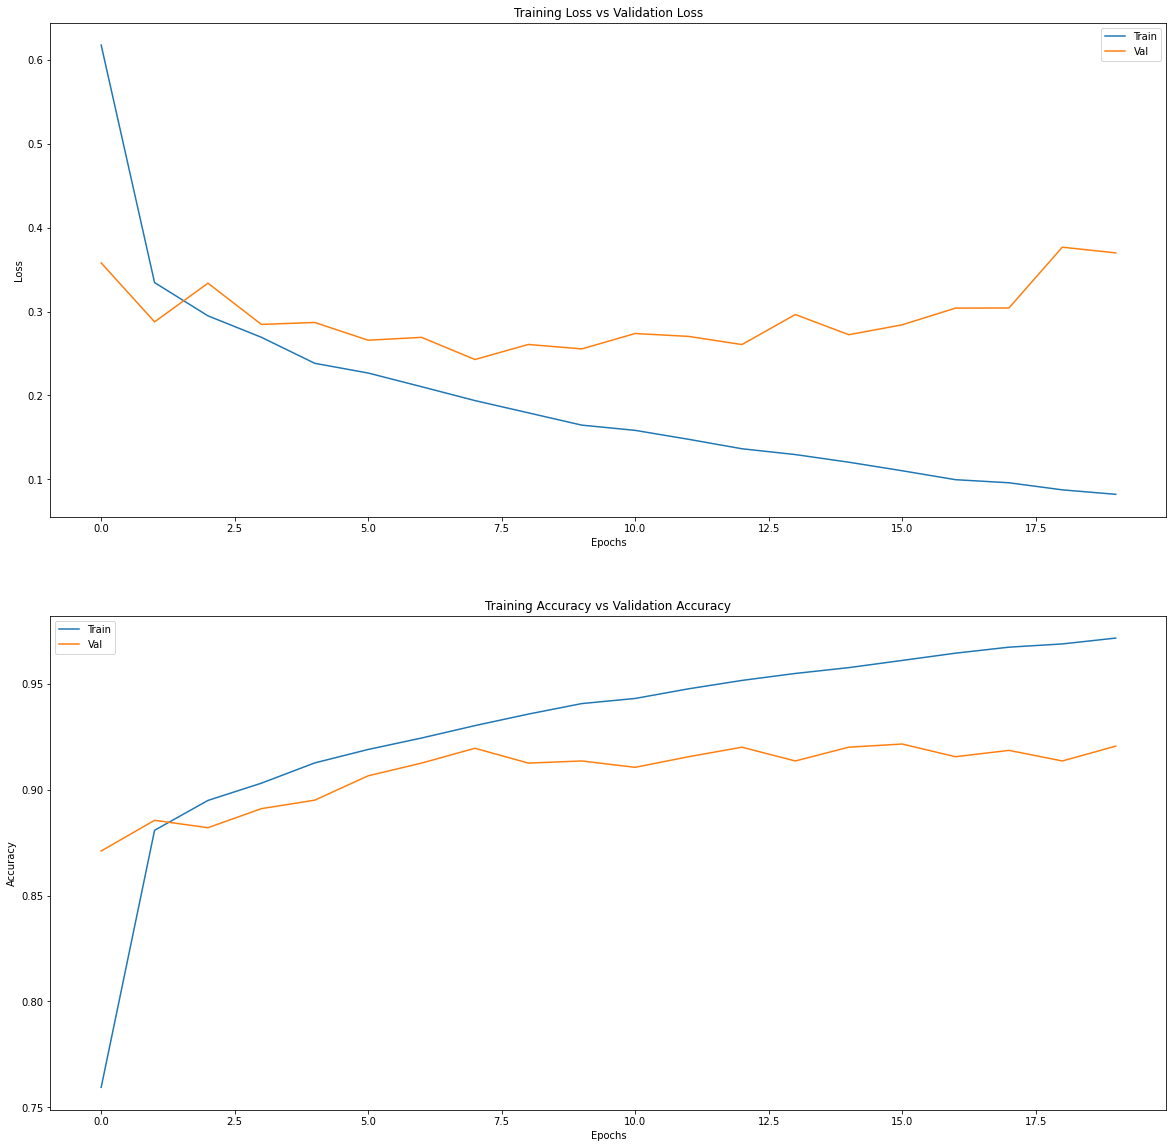

In [5]:
# Визуализация

fig, axs = plt.subplots(2, 1, figsize = (20,20))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [6]:
# Оценка

test_score = model.evaluate(x_test, y_test)
print("Test loss {:.4f}, accuracy {:.2f}%".format(test_score[0], test_score[1] * 100))

313/313 [==============================] - 39s 124ms/step - loss: 0.3864 - accuracy: 0.9145
Test loss 0.3864, accuracy 91.45%


---

### Оценка влияния увеличения ширины сети

In [7]:
result_width = []

In [8]:
def models_width(width_1 = 256, width_2 = 384, epochs = 10):
    
    model = Sequential()

    model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation = "bilinear", input_shape=x_train.shape[1:]))

    model.add(layers.Conv2D(96, 11, strides = 4, padding = 'same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides = 2))

    model.add(layers.Conv2D(width_1, 5, strides = 4, padding = 'same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides = 2))

    model.add(layers.Conv2D(width_2, 3, strides = 4, padding = 'same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(width_2, 3, strides = 4, padding = 'same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(width_1, 3, strides = 4, padding = 'same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation = 'relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation = 'relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(10, activation = 'softmax'))
    
    model.compile(optimizer = 'adam',
                  loss = losses.sparse_categorical_crossentropy, 
                  metrics = ['accuracy'])

    model.fit(x = x_train, y = y_train, 
                    batch_size = 64, 
                    epochs = epochs, 
                    validation_data = (x_val, y_val),
                    verbose = 1)
    
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print("Test loss {:.4f}, accuracy {:.2f}%".format(loss, accuracy * 100))
    
    result_width.append([width_1, width_2, loss, accuracy])
    
    return result_width

In [9]:
models_width(256, 384, epochs = 10)

Epoch 1/10
907/907 [==============================] - 612s 674ms/step - loss: 1.1335 - accuracy: 0.5291 - val_loss: 0.3307 - val_accuracy: 0.8740
Epoch 2/10
907/907 [==============================] - 620s 684ms/step - loss: 0.3402 - accuracy: 0.8777 - val_loss: 0.2951 - val_accuracy: 0.8940
Epoch 3/10
907/907 [==============================] - 601s 663ms/step - loss: 0.2929 - accuracy: 0.8934 - val_loss: 0.2595 - val_accuracy: 0.9040
Epoch 4/10
907/907 [==============================] - 597s 658ms/step - loss: 0.2628 - accuracy: 0.9042 - val_loss: 0.2707 - val_accuracy: 0.8985
Epoch 5/10
907/907 [==============================] - 595s 656ms/step - loss: 0.2497 - accuracy: 0.9109 - val_loss: 0.3281 - val_accuracy: 0.8840
Epoch 6/10
907/907 [==============================] - 599s 660ms/step - loss: 0.2318 - accuracy: 0.9187 - val_loss: 0.2616 - val_accuracy: 0.9115
Epoch 7/10
907/907 [==============================] - 596s 657ms/step - loss: 0.2099 - accuracy: 0.9254 - val_loss: 0.2401 -

[[256, 384, 0.30209630727767944, 0.913100004196167]]

In [10]:
models_width(384, 576, epochs = 10)

Epoch 1/10
907/907 [==============================] - 810s 892ms/step - loss: 1.1075 - accuracy: 0.5282 - val_loss: 0.3740 - val_accuracy: 0.8585
Epoch 2/10
907/907 [==============================] - 801s 883ms/step - loss: 0.3581 - accuracy: 0.8709 - val_loss: 0.3165 - val_accuracy: 0.8890
Epoch 3/10
907/907 [==============================] - 801s 883ms/step - loss: 0.3021 - accuracy: 0.8888 - val_loss: 0.2707 - val_accuracy: 0.9055
Epoch 4/10
907/907 [==============================] - 804s 886ms/step - loss: 0.2707 - accuracy: 0.9026 - val_loss: 0.2532 - val_accuracy: 0.9020
Epoch 5/10
907/907 [==============================] - 808s 891ms/step - loss: 0.2419 - accuracy: 0.9124 - val_loss: 0.2823 - val_accuracy: 0.9055
Epoch 6/10
907/907 [==============================] - 815s 898ms/step - loss: 0.2216 - accuracy: 0.9174 - val_loss: 0.2450 - val_accuracy: 0.9145
Epoch 7/10
907/907 [==============================] - 809s 891ms/step - loss: 0.2094 - accuracy: 0.9237 - val_loss: 0.2224 -

[[256, 384, 0.30209630727767944, 0.913100004196167],
 [384, 576, 0.25781452655792236, 0.9129999876022339]]

In [11]:
models_width(576, 864, epochs = 10)

Epoch 1/10
907/907 [==============================] - 1305s 1s/step - loss: 1.1967 - accuracy: 0.4993 - val_loss: 0.3616 - val_accuracy: 0.8685
Epoch 2/10
907/907 [==============================] - 1318s 1s/step - loss: 0.3646 - accuracy: 0.8695 - val_loss: 0.3025 - val_accuracy: 0.8885
Epoch 3/10
907/907 [==============================] - 1313s 1s/step - loss: 0.3092 - accuracy: 0.8876 - val_loss: 0.2905 - val_accuracy: 0.8980
Epoch 4/10
907/907 [==============================] - 1297s 1s/step - loss: 0.2737 - accuracy: 0.9001 - val_loss: 0.3038 - val_accuracy: 0.8930
Epoch 5/10
907/907 [==============================] - 1297s 1s/step - loss: 0.2464 - accuracy: 0.9113 - val_loss: 0.3057 - val_accuracy: 0.8915
Epoch 6/10
907/907 [==============================] - 1305s 1s/step - loss: 0.2343 - accuracy: 0.9156 - val_loss: 0.2647 - val_accuracy: 0.9070
Epoch 7/10
907/907 [==============================] - 1295s 1s/step - loss: 0.2181 - accuracy: 0.9216 - val_loss: 0.2825 - val_accuracy:

[[256, 384, 0.30209630727767944, 0.913100004196167],
 [384, 576, 0.25781452655792236, 0.9129999876022339],
 [576, 864, 0.28449517488479614, 0.9063000082969666]]

In [12]:
# Планировал сделать и этот шаг, но один e занимает более 40 минут & ноутбук на пределе

# models_width(864, 1296, epochs = 10)

In [13]:
import pandas as pd

# Оценка

pd.DataFrame(result_width, columns = ['width_1','width_2',
                              'loss', 'accuracy'
                              ]).\
                              sort_values('accuracy', ascending = False).head(3)

,width_1,width_2,loss,accuracy
0,256,384,0.302096,0.9131
1,384,576,0.257815,0.9130
2,576,864,0.284495,0.9063


---

### Оценка влияния увеличения глубины сети

In [14]:
result_depth = []

In [15]:
def models_depth(depth = 2, width_1 = 256, width_2 = 384, epochs = 10):
    
    model = Sequential()

    model.add(layers.experimental.preprocessing.Resizing(224, 224, interpolation = "bilinear", input_shape = x_train.shape[1:]))

    model.add(layers.Conv2D(96, 11, strides = 4, padding = 'same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides = 2))

    model.add(layers.Conv2D(width_1, 5, strides = 4, padding = 'same'))
    model.add(layers.Lambda(tf.nn.local_response_normalization))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling2D(3, strides = 2))
    
    for _ in range(depth):
        model.add(layers.Conv2D(width_2, 3, strides = 4, padding = 'same'))
        model.add(layers.Activation('relu'))

    model.add(layers.Conv2D(width_1, 3, strides = 2, padding = 'same'))
    model.add(layers.Activation('relu'))

    model.add(layers.Flatten())

    model.add(layers.Dense(4096, activation = 'relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(4096, activation = 'relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(10, activation = 'softmax'))
    
    model.compile(optimizer = 'adam',
                  loss = losses.sparse_categorical_crossentropy, 
                  metrics = ['accuracy'])

    model.fit(x = x_train, y = y_train, 
                    batch_size = 64, 
                    epochs = epochs, 
                    validation_data = (x_val, y_val),
                    verbose = 1)
    
    [loss, accuracy] = model.evaluate(x_test, y_test)
    print("Test loss {:.4f}, accuracy {:.2f}%".format(loss, accuracy * 100))
    
    result_depth.append([width_1, width_2, depth, loss, accuracy])
    
    return result_depth

In [16]:
models_depth(depth = 2, width_1 = 576, width_2 = 864, epochs = 10)

Epoch 1/10
907/907 [==============================] - 1305s 1s/step - loss: 2.3040 - accuracy: 0.0991 - val_loss: 2.3029 - val_accuracy: 0.1065
Epoch 2/10
907/907 [==============================] - 1322s 1s/step - loss: 2.3029 - accuracy: 0.0987 - val_loss: 2.3024 - val_accuracy: 0.1100
Epoch 3/10
907/907 [==============================] - 1328s 1s/step - loss: 2.3027 - accuracy: 0.1001 - val_loss: 2.3026 - val_accuracy: 0.1065
Epoch 4/10
907/907 [==============================] - 1340s 1s/step - loss: 2.3028 - accuracy: 0.0986 - val_loss: 2.3030 - val_accuracy: 0.0960
Epoch 5/10
907/907 [==============================] - 1338s 1s/step - loss: 2.3027 - accuracy: 0.1021 - val_loss: 2.3028 - val_accuracy: 0.1030
Epoch 6/10
907/907 [==============================] - 1337s 1s/step - loss: 2.3027 - accuracy: 0.1024 - val_loss: 2.3031 - val_accuracy: 0.0890
Epoch 7/10
907/907 [==============================] - 1354s 1s/step - loss: 2.3027 - accuracy: 0.0983 - val_loss: 2.3029 - val_accuracy:

[[576, 864, 2, 2.302610158920288, 0.10000000149011612]]

In [17]:
models_depth(depth = 3, width_1 = 576, width_2 = 864, epochs = 10)

Epoch 1/10
907/907 [==============================] - 1560s 2s/step - loss: 1.2172 - accuracy: 0.4968 - val_loss: 0.3659 - val_accuracy: 0.8640
Epoch 2/10
907/907 [==============================] - 1565s 2s/step - loss: 0.3724 - accuracy: 0.8679 - val_loss: 0.3104 - val_accuracy: 0.8895
Epoch 3/10
907/907 [==============================] - 1660s 2s/step - loss: 0.3164 - accuracy: 0.8863 - val_loss: 0.3364 - val_accuracy: 0.8850
Epoch 4/10
907/907 [==============================] - 1742s 2s/step - loss: 0.2825 - accuracy: 0.8972 - val_loss: 0.3257 - val_accuracy: 0.8955
Epoch 5/10
907/907 [==============================] - 1747s 2s/step - loss: 0.2516 - accuracy: 0.9086 - val_loss: 0.2825 - val_accuracy: 0.9005
Epoch 6/10
907/907 [==============================] - 1742s 2s/step - loss: 0.2344 - accuracy: 0.9149 - val_loss: 0.2851 - val_accuracy: 0.9095
Epoch 7/10
907/907 [==============================] - 1737s 2s/step - loss: 0.2149 - accuracy: 0.9213 - val_loss: 0.2720 - val_accuracy:

[[576, 864, 2, 2.302610158920288, 0.10000000149011612],
 [576, 864, 3, 0.2854299545288086, 0.9031999707221985]]

In [18]:
# Ноутбук не справляется

# models_depth(depth = 4, width_1 = 576, width_2 = 864, epochs = 10)

In [20]:
models_depth(depth = 2, width_1 = 384, width_2 = 576, epochs = 10)

Epoch 1/10
907/907 [==============================] - 829s 913ms/step - loss: 1.1283 - accuracy: 0.5366 - val_loss: 0.3684 - val_accuracy: 0.8660
Epoch 2/10
907/907 [==============================] - 784s 864ms/step - loss: 0.3529 - accuracy: 0.8738 - val_loss: 0.3051 - val_accuracy: 0.8880
Epoch 3/10
907/907 [==============================] - 777s 857ms/step - loss: 0.2894 - accuracy: 0.8965 - val_loss: 0.2783 - val_accuracy: 0.9015
Epoch 4/10
907/907 [==============================] - 785s 866ms/step - loss: 0.2700 - accuracy: 0.9024 - val_loss: 0.2566 - val_accuracy: 0.9045
Epoch 5/10
907/907 [==============================] - 808s 891ms/step - loss: 0.2436 - accuracy: 0.9126 - val_loss: 0.2641 - val_accuracy: 0.9030
Epoch 6/10
907/907 [==============================] - 821s 905ms/step - loss: 0.2302 - accuracy: 0.9170 - val_loss: 0.2563 - val_accuracy: 0.9105
Epoch 7/10
907/907 [==============================] - 831s 916ms/step - loss: 0.2114 - accuracy: 0.9249 - val_loss: 0.2459 -

[[576, 864, 2, 2.302610158920288, 0.10000000149011612],
 [576, 864, 3, 0.2854299545288086, 0.9031999707221985],
 [384, 576, 2, 0.29686304926872253, 0.9063000082969666]]

In [21]:
models_depth(depth = 3, width_1 = 384, width_2 = 576, epochs = 10)

Epoch 1/10
907/907 [==============================] - 964s 1s/step - loss: 1.2909 - accuracy: 0.4588 - val_loss: 0.3919 - val_accuracy: 0.8580
Epoch 2/10
907/907 [==============================] - 945s 1s/step - loss: 0.3857 - accuracy: 0.8642 - val_loss: 0.3043 - val_accuracy: 0.8860
Epoch 3/10
907/907 [==============================] - 942s 1s/step - loss: 0.3106 - accuracy: 0.8877 - val_loss: 0.2949 - val_accuracy: 0.8940
Epoch 4/10
907/907 [==============================] - 938s 1s/step - loss: 0.2818 - accuracy: 0.9002 - val_loss: 0.2662 - val_accuracy: 0.9040
Epoch 5/10
907/907 [==============================] - 940s 1s/step - loss: 0.2532 - accuracy: 0.9081 - val_loss: 0.2872 - val_accuracy: 0.9085
Epoch 6/10
907/907 [==============================] - 938s 1s/step - loss: 0.2347 - accuracy: 0.9148 - val_loss: 0.2589 - val_accuracy: 0.9050
Epoch 7/10
907/907 [==============================] - 940s 1s/step - loss: 0.2291 - accuracy: 0.9197 - val_loss: 0.2483 - val_accuracy: 0.9095

[[576, 864, 2, 2.302610158920288, 0.10000000149011612],
 [576, 864, 3, 0.2854299545288086, 0.9031999707221985],
 [384, 576, 2, 0.29686304926872253, 0.9063000082969666],
 [384, 576, 3, 0.326115220785141, 0.9043999910354614]]

In [22]:
# Ноутбук не справляется

# models_depth(depth = 4, width_1 = 384, width_2 = 576, epochs = 10)

In [23]:
# Оценка

pd.DataFrame(result_depth, columns = ['width_1', 'width_2','depth',
                              'loss', 'accuracy'
                              ]).\
                              sort_values('accuracy', ascending = False).head(4)

,width_1,width_2,depth,loss,accuracy
2,384,576,2,0.296863,0.9063
3,384,576,3,0.326115,0.9044
1,576,864,3,0.285430,0.9032
0,576,864,2,2.302610,0.1000


---

**Вывод:**

- Увеличение ширины (может) приводить к росту точности.
- Увеличение глубины (количества слоев) может по-разному влиять на точность.